In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df_sector = df
df

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [4]:
#Cleaning up some data
list = df.replace({'BRK.B':'BRK-B', 'BF.B':'BF-B'})
indexNames = list[ list['Symbol'] == 'OGN' ].index
list.drop(indexNames , inplace=True)
newlist = list['Symbol'].to_numpy()
newlist

array(['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADBE', 'AMD', 'AAP',
       'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALXN',
       'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN',
       'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP',
       'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'AOS',
       'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T',
       'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC',
       'BK', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIO', 'BIIB', 'BLK', 'BA',
       'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BF-B', 'CHRW',
       'COG', 'CDNS', 'CZR', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR',
       'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CERN',
       'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI',
       'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS',
       'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ',
 

In [5]:
from urllib.error import URLError, HTTPError
from urllib.request import Request, urlopen

news_tables = {}
tickers = newlist
finwiz_url = 'https://finviz.com/quote.ashx?t='
for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'}) 
    try:
      response = urlopen(req)  

    except URLError as e:
      print(url)
    # else:
      # Process data get from the URL opened
      # If an exception has been catch, you won't 
      # enter in this else block
      # print("No problem!")

    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table


In [6]:
news_table

="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Motley Fool</span></div></div></td></tr>
<tr><td align="right" width="130">04:20PM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://www.investors.com/news/technology/zts-stock-zoetis-earnings-q4-2020/?src=A00220" target="_blank">Zoetis Issues Bullish 2021 Outlook; But Shares Dip From Buy Point</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Investor's Business Daily</span></div></div></td></tr>
<tr><td align="right" width="130">08:41AM  </td><td align="left"><div class="news-link-container"><div class="news-link-left"><a class="tab-link-news" href="https://finance.yahoo.com/news/zoetis-q4-earnings-insights-134119770.html" target="_blank">Zoetis: Q4 Earnings Insights</a></div><div class="news-link-right"><span style="color:#aa6dc0;font-size:9px"> Benzinga</span></div></div></td></tr>
<tr><td align="right" width="130">08:

In [7]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text'
    hyperlink = table_row.a.get('href') 
    print(a_text)
    print(td_text)
    print(hyperlink)
    # Exit after printing 4 rows of data
    if i == 3:
        break

UPDATE 3-Walmart's Flipkart, Amazon challenge India court order on antitrust probe
Jun-17-21 01:41AM  
https://finance.yahoo.com/news/1-walmarts-flipkart-challenges-india-054122276.html
Walmart's Flipkart, Amazon challenge India court order on antitrust probe
12:58AM  
https://finance.yahoo.com/news/walmarts-flipkart-challenges-india-court-045815009.html
Walmart's Flipkart challenges India court order on antitrust probe-sources
12:54AM  
https://finance.yahoo.com/news/walmarts-flipkart-challenges-india-court-045454721.html
Adobe Data Suggests Amazons Prime Day Fashion Games Not Strong
Jun-16-21 09:25PM  
https://finance.yahoo.com/news/adobe-data-suggests-amazon-prime-012528557.html


In [8]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        hyperlink = x.a.get('href')
        
        # Append ticker, date, time and headline, news URL as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text, hyperlink])

In [9]:
parsed_news

://finance.yahoo.com/news/aes-wins-annual-edison-award-204500098.html'],
 ['AES',
  'May-27-21',
  '01:01PM',
  'Top Utilities Stocks for June 2021',
  'https://www.investopedia.com/top-utilities-stocks-4582243?utm_campaign=quote-yahoo&utm_source=yahoo&utm_medium=referral'],
 ['AES',
  'May-27-21',
  '09:01AM',
  'Is AES Corporation Stock a Buy?',
  'https://www.fool.com/investing/2021/05/27/is-aes-corporation-stock-a-buy/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article'],
 ['AES',
  'May-10-21',
  '08:00PM',
  'AES sees opportunity as Brazil turns to wind power',
  'http://www.ft.com/cms/s/3b718bd5-6fe3-4e2b-8897-866ec1a91cd8,s01=1.html?ftcamp=traffic/partner/feed_headline/us_yahoo/auddev'],
 ['AES',
  'May-06-21',
  '08:30PM',
  'AES Corp (AES) Q1 2021 Earnings Call Transcript',
  'https://www.fool.com/earnings/call-transcripts/2021/05/06/aes-corp-aes-q1-2021-earnings-call-transcript/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm

In [10]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline', 'hyperlink']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,hyperlink,neg,neu,pos,compound
0,MMM,2021-06-15,10:20AM,Honeywell closes two mask facilities amid pand...,https://finance.yahoo.com/video/honeywell-clos...,0.000,1.000,0.000,0.0000
1,MMM,2021-06-14,05:50PM,3M (MMM) Stock Sinks As Market Gains: What You...,https://finance.yahoo.com/news/3m-mmm-stock-si...,0.000,0.806,0.194,0.3400
2,MMM,2021-06-11,08:17AM,Love Dividends? 3 Stocks You Might Want to Buy,https://www.fool.com/investing/2021/06/11/love...,0.000,0.522,0.478,0.6705
3,MMM,2021-06-10,12:03PM,3 Top Industrial Dividend Stocks to Buy in June,https://www.fool.com/investing/2021/06/10/3-to...,0.000,0.795,0.205,0.2023
4,MMM,2021-06-10,08:42AM,3M helps U.S. Marshals seize over one million ...,https://finance.yahoo.com/news/3m-helps-u-mars...,0.115,0.727,0.158,0.1779


In [11]:
# folder = pathlib.Path(".")
# filename = "News_SP500_Sentiment.csv"
# filepath = folder / filename
parsed_and_scored_news.to_csv('News_SP500_Sentiment.csv')

In [12]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()


In [13]:
mean_scores

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13,NaN,NaN,NaN,0.114757,0.311900,NaN,NaN,-0.526700,NaN,-0.03610,...,NaN,NaN,0.111750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-14,0.27115,0.0000,NaN,0.085552,-0.079925,NaN,NaN,-0.020633,0.11090,0.25530,...,NaN,NaN,0.073986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-15,NaN,0.3117,NaN,0.073688,NaN,NaN,0.296,0.000000,0.19425,-0.26335,...,0.1700,NaN,0.248260,NaN,NaN,NaN,NaN,NaN,NaN,NaN


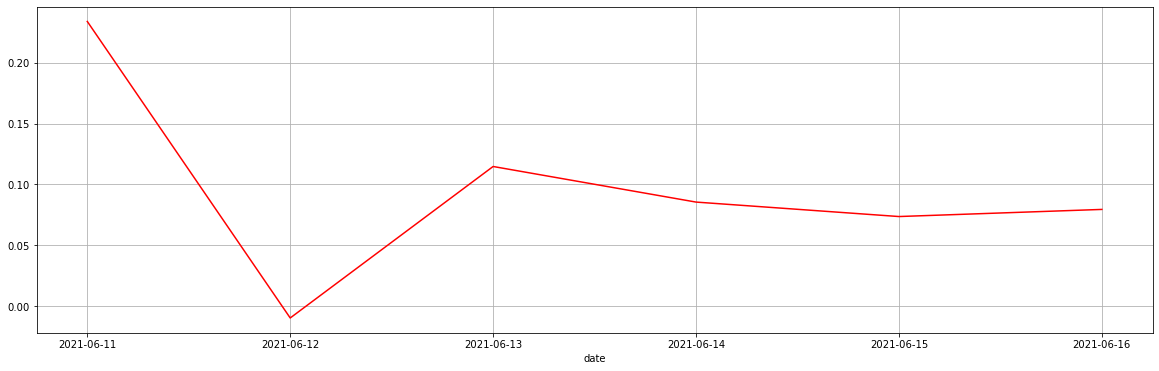

In [14]:
plt.rcParams['figure.figsize'] = [20, 6]

# mean_scores
# Plot a bar chart with pandas
example = mean_scores['AAPL']
example.plot(kind = 'line',x='date',y='mean_scores',color='red')
plt.grid()